# Case Study

We will begin by stating the libraries we will use and reading our dataset

In [629]:
import pandas as pd
import os
import seaborn as sb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from patsy import dmatrices
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

I will just remove the first, unnamed column and have a glipse of how the data look like.

In [536]:
# Getting to know the data #
df = pd.read_csv("biological_data.csv")
df=df.drop('Unnamed: 0', 1)
df.head()

/var/folders/b2/2k12p9m914v4zvgfqxmqvlg80000gn/T/ipykernel_66920/396029250.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df=df.drop('Unnamed: 0', 1)


,Y,X1,X2,X3,X4,X5,X6
0,5000,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,82.277778,106.555556,-4.522222e+01
1,138,human,XSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQWMFGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAA...,79.444444,103.444444,-4.400000e+01
2,5000,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,79.444444,103.444444,-4.400000e+01
3,5000,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,85.444444,108.888889,-9.666667e+00
4,5000,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,50.611111,85.444444,1.233581e-15


In [537]:
df.dtypes

Y       int64
X1     object
X2     object
X3     object
X4    float64
X5    float64
X6    float64
dtype: object

In [538]:
df.describe()

,Y,X4,X5,X6
count,1995.000000,1995.000000,1995.000000,1995.000000
mean,5853.522306,87.407331,111.003594,-34.522743
std,8014.699598,13.840506,9.799072,28.323315
min,0.000000,43.055556,78.333333,-123.777778
25%,47.000000,78.305556,104.555556,-52.666667
50%,1103.000000,87.500000,111.111111,-34.666667
75%,5000.000000,97.722222,118.111111,-16.277778
max,20000.000000,128.888889,142.777778,51.333333


Here we notice a couple of things. Our response variable is an integer response variable and we aim to explain it with a mixed of continuous and non-numeric covariates.

We now proceed to understand how the variable we plan to predict behaves. And couple of things are to be noted:
 
 - More than 75% of the sample takes values below 5000
 - About half of the sample takes values below 1000

array([[<AxesSubplot:title={'center':'Y'}>]], dtype=object)

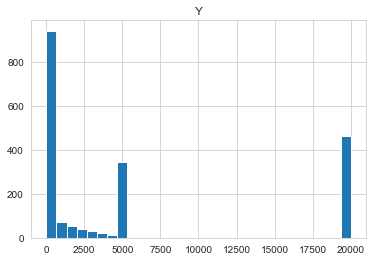

In [539]:
df.hist(column="Y",bins=30)
#df.boxplot(column="Y")

Now, we focus on understanding the characteristics of the non-numeric explanatory variables.

In [540]:
df[["X1","X2","X3"]].describe()

,X1,X2,X3
count,1995,1995,1995
unique,1,10,9
top,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...
freq,1995,509,509


Note:

- X1 has no variabbility. It is a 1-level factor. It has nothing to offer as a explanatory variable of the variation in Y.
- X2 and X3 have 10 and 9 levels respectively. Are these too many levels? Do we have a way to learn from them and then group them?

We now try to understand how both X2 and X3 interact with the response variable. As I do not have any prior knowledge about X2 and X3, I begin by regarding them as categorical variables and renaming the categories.

In [541]:
number = LabelEncoder()
df['X2'] = number.fit_transform(df['X2'].astype('str'))
df['X3'] = number.fit_transform(df['X3'].astype('str'))
df['X2']=df['X2'].astype('category')
df['X3']=df['X3'].astype('category')

In [542]:
df['X2'].value_counts()

4    509
3    310
0    239
6    181
9    172
7    171
5    162
1    142
8     90
2     19
Name: X2, dtype: int64

In [543]:
df['X3'].value_counts()

2    509
8    411
7    310
5    258
0    181
1    162
3    142
4     19
6      3
Name: X3, dtype: int64

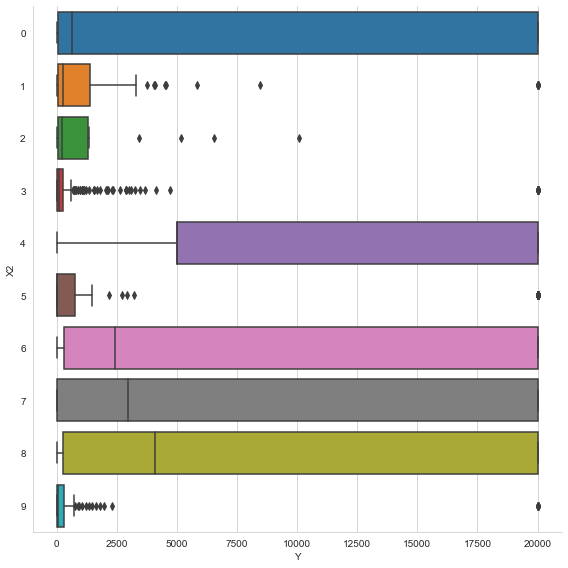

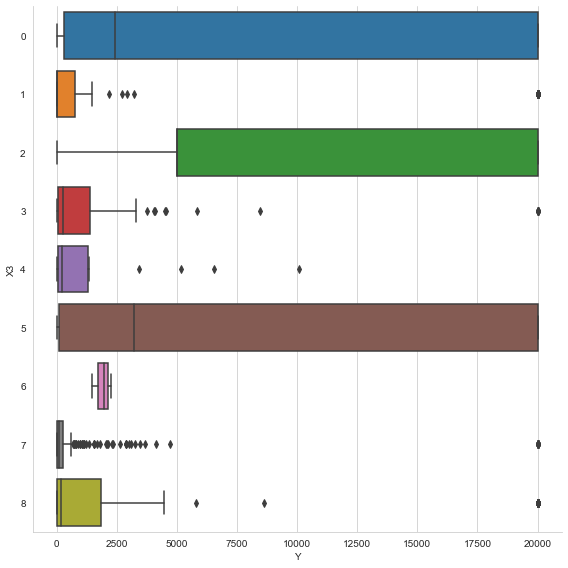

In [544]:
g = sb.catplot(y='X2', x='Y', kind="box", data=df, height=8)
g = sb.catplot(y='X3', x='Y', kind="box", data=df, height=8)


A quick inspection of the relation between X2 and Y let us see that: 

 - Level 2 has too few cases and could be assigned into one category
 - Levels 0,6,7 and 8 span the whole range of Y and could be candidates for being regrupped
 - Levels 3,5 and 9 behave similarly (low variability, take mostly low values of Y) and could make up another category
 - Level 2 could be joined with level 1 into another level
 
Whereas from the relation between X3 and Y we get:
 
 - Levels 0 and 5 are the only levels that span the whole range of Y. Hence, they could be grouped into one category.
   Level 2 could be possibly included into this category.
 - Levels 3,4 and 8 can be grouped into one category
 - Finally, levels 1 and 6 could be included into a third category.

Now, regarding the continuous explanatory variables, we now plot them in order to find out how they relate with each other and with Y and compute their Pearson coefficient of correlation.


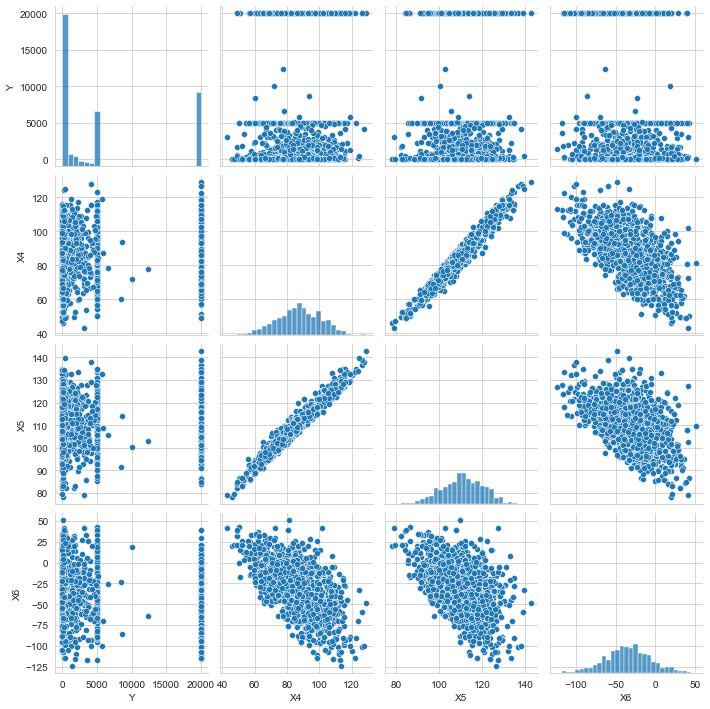

In [545]:
sb.set_style('whitegrid')
g1 = sb.pairplot(df[['Y','X4','X5','X6']])
plt.show(g1)

In [546]:
df.corr()

,Y,X4,X5,X6
Y,1.000000,0.032968,0.034334,-0.074900
X4,0.032968,1.000000,0.978441,-0.569942
X5,0.034334,0.978441,1.000000,-0.496264
X6,-0.074900,-0.569942,-0.496264,1.000000


We can notice some few thing from the figures:

 - There is perfect positive correlation between X4 and X5. Hence, we can get rid of one of them.
 - There is negative association between X6 and both X4 and X5
 - The correlation between X4,X5 and X6 and Y is low.
 
From the beginning of this case, we could notice that the behavior of Y is too "clusterized" and better understanding and prectictability of this variable could be reached if we transform it into a binary (or categorical?) variable. We now analyze this new variable in relation with the variables X2-X6

In [547]:
import numpy as np
df['Ybin'] = np.digitize(df['Y'],bins=[50])

In [548]:
X2_crosstab = pd.crosstab(df['X2'], 
                            df['Ybin'],
                                margins = False,
                         normalize="index")
X2_crosstab

Ybin,0,1
X2,,
0,0.255230,0.744770
1,0.253521,0.746479
2,0.263158,0.736842
3,0.464516,0.535484
4,0.019646,0.980354
5,0.543210,0.456790
6,0.104972,0.895028
7,0.286550,0.713450
8,0.100000,0.900000


In [549]:
X3_crosstab = pd.crosstab(df['X3'], 
                            df['Ybin'],
                                margins = False,
                         normalize="index")
X3_crosstab

Ybin,0,1
X3,,
0,0.104972,0.895028
1,0.543210,0.456790
2,0.019646,0.980354
3,0.253521,0.746479
4,0.263158,0.736842
5,0.224806,0.775194
6,0.000000,1.000000
7,0.464516,0.535484
8,0.355231,0.644769


We again plot the relation between the binary response variable and the threee continuous variables. 

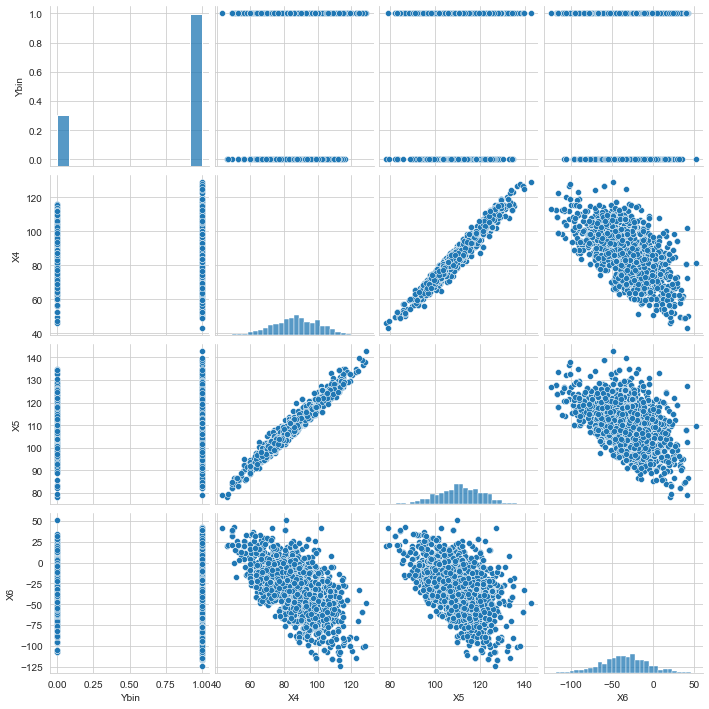

In [550]:
g1 = sb.pairplot(df[['Ybin','X4','X5','X6']])
plt.show(g1)

We see no clear relation between X4-X6 and Y.

As we finish the descriptive and exploratory stage there are some actions we will take before we continue:

 - We will fit models with both Y and Y1 to enrich our discussion and show how differently they can be used.
 - X1 won't be considered as a candidate variability as it has no variability and therefore will not explain the variation in Y.
 - X2 and X3 will be grouped to reduce the number of categories and thus gain interpretability.
 - X4 will be removed from the group of candidate variables as it is almost perfectly correlated with X5. 
 - Both X5 and X6 will be standardized to avoid issues with the values of the coefficients.

Based on the knowledge we have so far of our problem we attempt the next models for predicting Y in two scenarios, when Y is assumed numeric and when Y is assumed binary.

Scenario 1: Discrete response

 - Negative binomial regression
 
Scenario 2: Binary response

 - Logistic regression
 - Neural network

Just before starting, we will create training and testing datasets, scale the continuous explanatory variables and transform the categorical ones.

In [551]:
df.dtypes
X_1 = df[['X2','X3']]
X_1 = pd.get_dummies(data=X_1, drop_first=True)
X_2 = df[['X5','X6']]
scaler = StandardScaler()
X_2[['X5','X6']] = scaler.fit_transform(X_2[['X5','X6']])
X = pd.concat([X_1, X_2], axis=1)
X = sm.add_constant(X)
Y = df[['Y','Ybin']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [552]:
NBModel = sm.GLM(y_train['Y'], X_train, family=sm.families.NegativeBinomial()).fit()
print(NBModel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                 1396
Model:                            GLM   Df Residuals:                     1383
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13132.
Date:                Fri, 25 Feb 2022   Deviance:                       5791.4
Time:                        10:22:42   Pearson chi2:                 5.88e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0689      0.053    132.411      0.0

In [553]:
nb2_predictions = NBModel.get_prediction(X_test)

In [554]:
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)


              mean      mean_se  mean_ci_lower  mean_ci_upper
1747   9944.133688  1034.368044    8110.110010   12192.904250
1648   8107.705803   755.105078    6754.947319    9731.370250
56     9233.896819   484.787337    8330.982488   10234.669270
1784   7945.106333   810.450395    6505.367685    9703.481446
913    9486.636981   855.346704    7949.963291   11320.339216
...            ...          ...            ...            ...
1842   1278.056103   127.523095    1051.036802    1554.110570
1397  11055.496625  1479.348156    8505.072934   14370.718108
1749   8820.317928   918.242423    7192.329769   10816.802184
812    8988.300714   599.505376    7886.854037   10243.571053
45     9321.706270   495.789467    8398.910128   10345.890889

[599 rows x 4 columns]


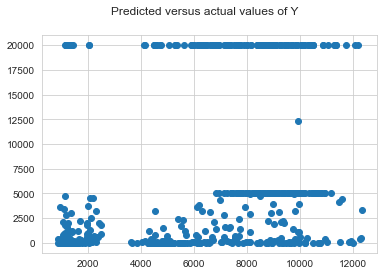

In [555]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['Y']
fig = plt.figure()
fig.suptitle('Predicted versus actual values of Y')
plt.scatter(predicted_counts, actual_counts)
#actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
#plt.legend(handles=[predicted, actual])
plt.show()

In [556]:
print('RMSE: ', np.sqrt(mean_squared_error(predicted_counts,actual_counts))) 

RMSE:  7267.368018469549


Now we are ready to perform prediction of Y1 using both logistic regression and Neural Networks

In [581]:
LRmodel = LogisticRegression(solver='liblinear', random_state=0)
LRmodel.fit(X_train,y_train['Ybin'])

LogisticRegression(random_state=0, solver='liblinear')

In [582]:
LRmodel.predict_proba(X_test)

array([[0.12973483, 0.87026517],
       [0.12378413, 0.87621587],
       [0.02220445, 0.97779555],
       ...,
       [0.11130566, 0.88869434],
       [0.01916391, 0.98083609],
       [0.02168499, 0.97831501]])

In [583]:
LRmodel.coef_

array([[ 0.627389  , -0.22536751, -0.0887359 , -0.54853431,  1.26243166,
        -0.59151842,  0.5943757 , -0.48926061,  0.94680504, -0.85433254,
        -0.59151842,  1.26243166, -0.22536751, -0.0887359 ,  0.20219936,
         0.25534506, -0.54853431, -0.23280665,  0.04313187, -0.08652077]])

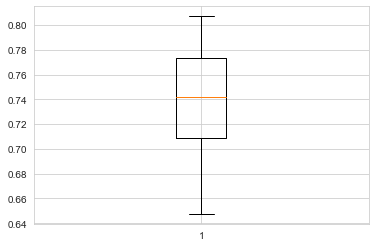

In [584]:
# prepare models
scoring = 'accuracy'
kfold = model_selection.KFold(n_splits=10)
cv_results = model_selection.cross_val_score(LRmodel, X_train, y_train['Ybin'], cv=kfold, scoring=scoring)
#msg = "%s: %f (%f)" % ( cv_results.mean(), cv_results.std())
#print(msg)
# boxplot algorithm comparison
fig = plt.figure()
plt.boxplot(cv_results)
plt.show()

In [585]:
cv_results

array([0.76428571, 0.70714286, 0.80714286, 0.78571429, 0.71428571,
       0.73571429, 0.77697842, 0.70503597, 0.64748201, 0.74820144])

In [603]:
LRpredict = LRmodel.predict(X_test)

In [587]:
confusion_matrix(y_test['Ybin'], LRmodel.predict(X_test))

array([[ 22, 136],
       [ 15, 426]])

In [588]:
print(classification_report(y_test['Ybin'], LRmodel.predict(X_test)))

              precision    recall  f1-score   support

           0       0.59      0.14      0.23       158
           1       0.76      0.97      0.85       441

    accuracy                           0.75       599
   macro avg       0.68      0.55      0.54       599
weighted avg       0.71      0.75      0.68       599



In [651]:
score = LRmodel.score(X_test, y_test['Ybin'])
score

0.7479131886477463

In [652]:
score = LRmodel.score(X_train, y_train['Ybin'])
score

0.7464183381088825

We finalize with a Neural Network model for predicting the output Ybin

In [589]:
# define the keras model
NNmodel = Sequential()
NNmodel.add(Dense(16, input_dim=20, activation='relu'))
NNmodel.add(Dense(8, activation='relu'))
NNmodel.add(Dense(4, activation='relu'))
NNmodel.add(Dense(1, activation='sigmoid'))

In [590]:
NNmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [591]:
mod_hist = NNmodel.fit(X_train,y_train['Ybin'], validation_split=0.25,epochs=200, batch_size=10)

Epoch 1/200
105/105 [==============================] - 1s 3ms/step - loss: 0.6344 - accuracy: 0.6657 - val_loss: 0.5844 - val_accuracy: 0.7135
Epoch 2/200
105/105 [==============================] - 0s 2ms/step - loss: 0.5123 - accuracy: 0.7631 - val_loss: 0.5461 - val_accuracy: 0.7135
Epoch 3/200
105/105 [==============================] - 0s 1ms/step - loss: 0.4788 - accuracy: 0.7631 - val_loss: 0.5234 - val_accuracy: 0.7135
Epoch 4/200
105/105 [==============================] - 0s 1ms/step - loss: 0.4615 - accuracy: 0.7631 - val_loss: 0.5081 - val_accuracy: 0.7106
Epoch 5/200
105/105 [==============================] - 0s 1ms/step - loss: 0.4508 - accuracy: 0.7650 - val_loss: 0.4937 - val_accuracy: 0.7221
Epoch 6/200
105/105 [==============================] - 0s 1ms/step - loss: 0.4449 - accuracy: 0.7736 - val_loss: 0.4901 - val_accuracy: 0.7192
Epoch 7/200
105/105 [==============================] - 0s 1ms/step - loss: 0.4414 - accuracy: 0.7746 - val_loss: 0.4869 - val_accuracy: 0.7278

In [592]:
accuracy = NNmodel.evaluate(X_train, y_train['Ybin'])


44/44 [==============================] - 0s 844us/step - loss: 0.4018 - accuracy: 0.7887


In [593]:
accuracy = NNmodel.evaluate(X_test, y_test['Ybin'])

19/19 [==============================] - 0s 977us/step - loss: 0.5475 - accuracy: 0.7496


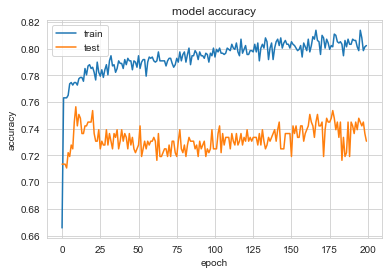

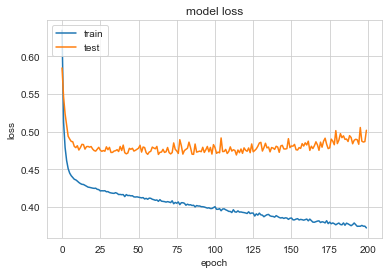

In [594]:
# summarize history for accuracy
plt.plot(mod_hist.history['accuracy'])
plt.plot(mod_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(mod_hist.history['loss'])
plt.plot(mod_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [621]:
NNy_pred = NNmodel.predict(X_test).ravel()
LRy_pred = LRmodel.predict_proba(X_test)[:,1]

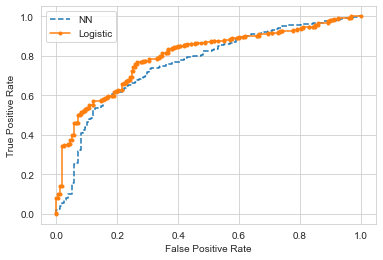

In [622]:
NN_fpr, NN_tpr, NN_thresholds = roc_curve(y_test['Ybin'], NNy_pred)
LR_fpr, LR_tpr, LR_thresholds = roc_curve(y_test['Ybin'], LRy_pred)
NNauc_keras = auc(NN_fpr, NN_tpr)
LRauc_keras = auc(LR_fpr, LR_tpr)
# plot the roc curve for the model
plt.plot(NN_fpr, NN_tpr, linestyle='--', label='NN')
plt.plot(LR_fpr, LR_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
#plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

In [626]:
nn_auc = roc_auc_score(y_test['Ybin'], NNy_pred)
lr_auc = roc_auc_score(y_test['Ybin'], LRy_pred)
print(nn_auc);print(lr_auc)

0.7607422715921811
0.7984873274204196


In [648]:
LR_precision, LR_recall, LR_thresholds = precision_recall_curve(y_test['Ybin'], LRy_pred)
NN_precision, NN_recall, NN_threshold = precision_recall_curve(y_test['Ybin'], NNy_pred)
NNauc = auc(NN_recall, NN_precision)
LRauc = auc(LR_recall, LR_precision)
print(NNauc)
print(LRauc)

0.8790840203535235
0.9164286618704246


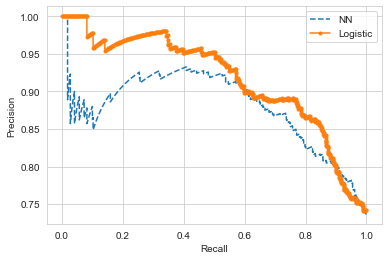

In [647]:
# plot the roc curve for the model
plt.plot(NN_recall, NN_precision, linestyle='--', label='NN')
plt.plot(LR_recall, LR_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
#plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

In [645]:
auc(LR_recall, LR_precision)

0.9164286618704246